In [4]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils  import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()
import tensorflow as tf
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings('ignore')

<ipython-input-4-25d09fd934d1>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download adityajn105/flickr8k

100% 1.03G/1.04G [00:46<00:00, 24.5MB/s]
100% 1.04G/1.04G [00:46<00:00, 24.1MB/s]


In [16]:
! kaggle datasets download lakshmisruthikotha/flickr8k-text

100% 1.71M/1.71M [00:01<00:00, 1.75MB/s]
100% 1.71M/1.71M [00:01<00:00, 1.55MB/s]


In [17]:
! unzip flickr8k-text.zip

Archive:  flickr8k-text.zip
  inflating: Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  


In [6]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [18]:
dir_Flickr_jpg = "/content/Images"
## The location of the caption file
dir_Flickr_text = "/content/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [19]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


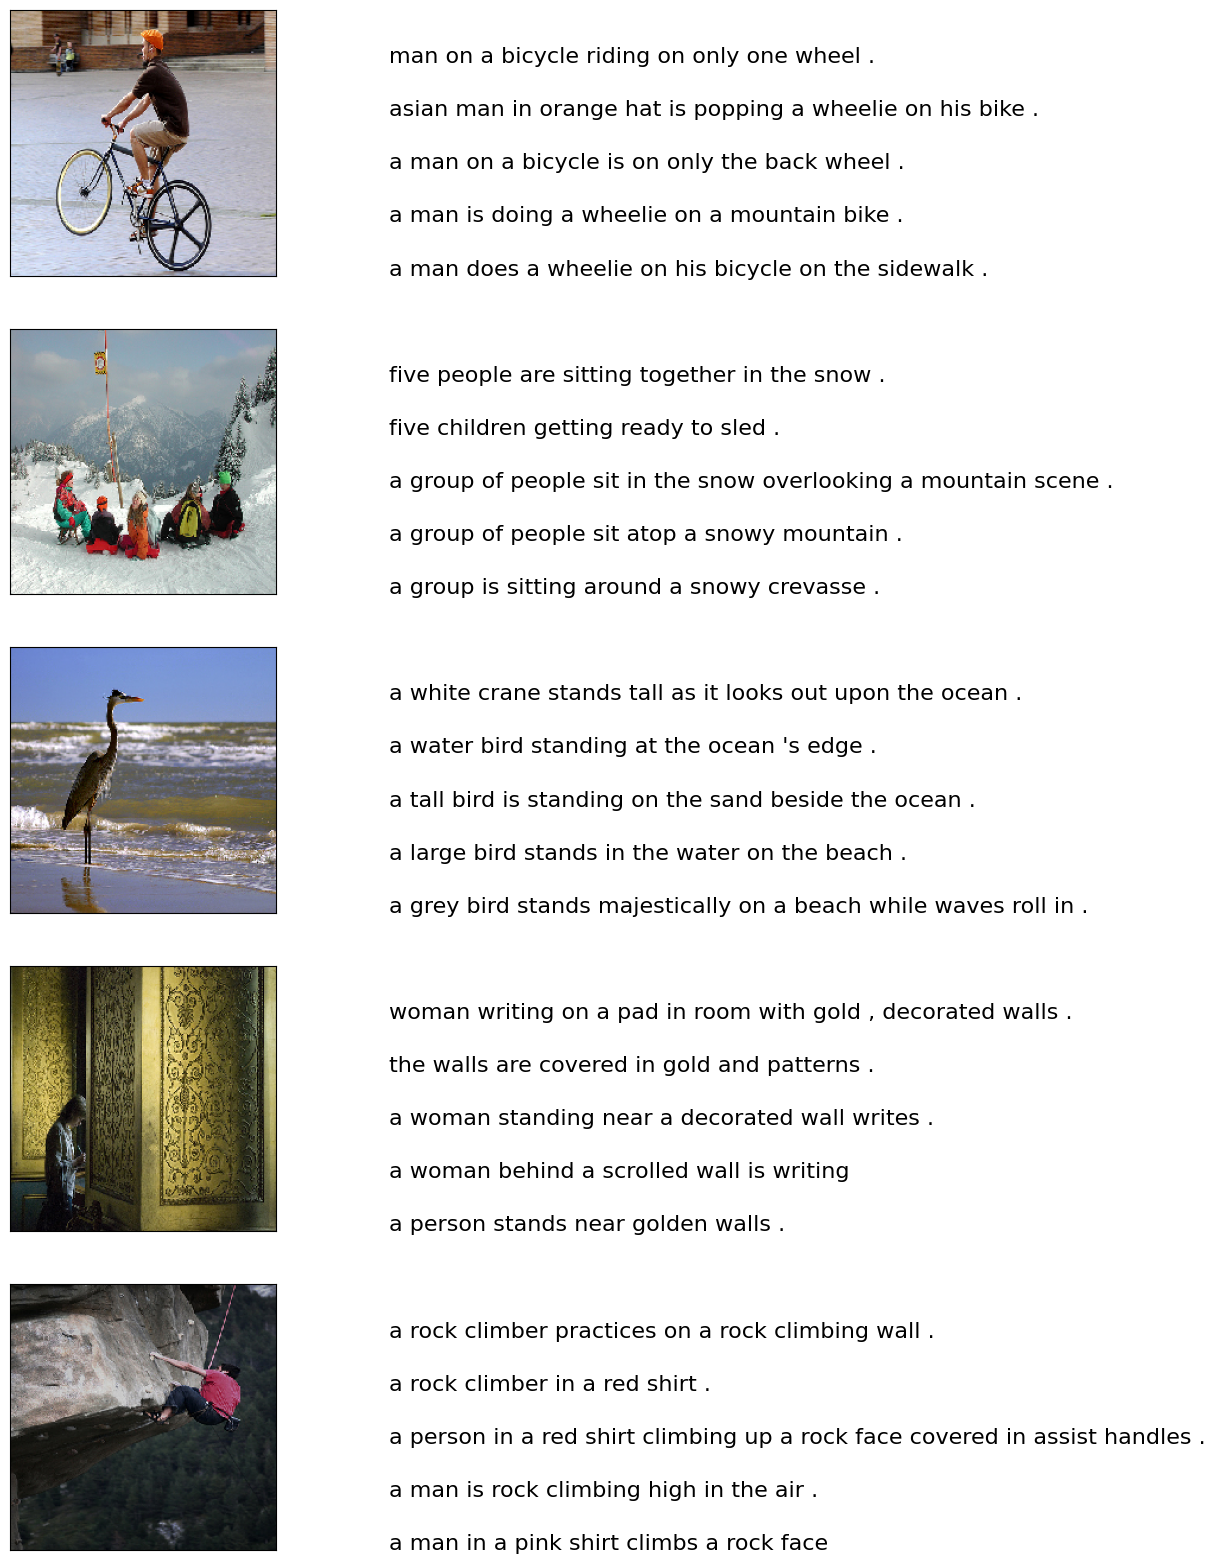

In [20]:
from tensorflow.keras.utils import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5  # Displaying 5 images from the dataset
npix = 224
target_size = (npix, npix, 3)

count = 1 
fig = plt.figure(figsize=(10,20))

for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1
plt.show()    

In [21]:
# Defining a function to calculate the top 5 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({'word':list(ct.keys()), "count":list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word", "count"]]
    
    return (dfword)

dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975
3  the  18419
4   on  10744

In [22]:
import string
text_original = "I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me"

print("Origial sentense: ",text_original)
print("\nRemoving Punctuations...")

# creating a function that removes punctuation in the sentences
def remove_punctuation(text_original):
    text_without_punct = text_original.translate(str.maketrans('','',string.punctuation))
    return text_without_punct

text_without_punct = remove_punctuation(text_original)
print(text_without_punct)

print("\nRemoving a single character...")

# creating a function that removes single character
def removing_single_char(text):
    text_len_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_len_greater_than_one += " " + word
    return text_len_greater_than_one

text_len_greater_than_one = removing_single_char(text_without_punct)
print(text_len_greater_than_one)

print("\nRemoving numeric values...")

# creating a function that removes numerical values
def remove_numeric(text, printTF=False):
    text_without_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("     {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_without_num += " "+ word
    return text_without_num

text_without_num = remove_numeric(text_len_greater_than_one, printTF=True)
print(text_without_num)

Origial sentense:  I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me

Removing Punctuations...
I ate 8 burgers and 4 pizzas its 944 am can you play chess with me

Removing a single character...
 ate burgers and pizzas its 944 am can you play chess with me

Removing numeric values...
     ate        : True
     burgers    : True
     and        : True
     pizzas     : True
     its        : True
     944        : False
     am         : True
     can        : True
     you        : True
     play       : True
     chess      : True
     with       : True
     me         : True
 ate burgers and pizzas its am can you play chess with me


In [23]:
def text_clean(text_original):
    
    text = remove_punctuation(text_original)
    text = removing_single_char(text)
    text = remove_numeric(text)
    
    return text

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt['caption'].iloc[i] = newcaption

Vocabulary Size: 8763


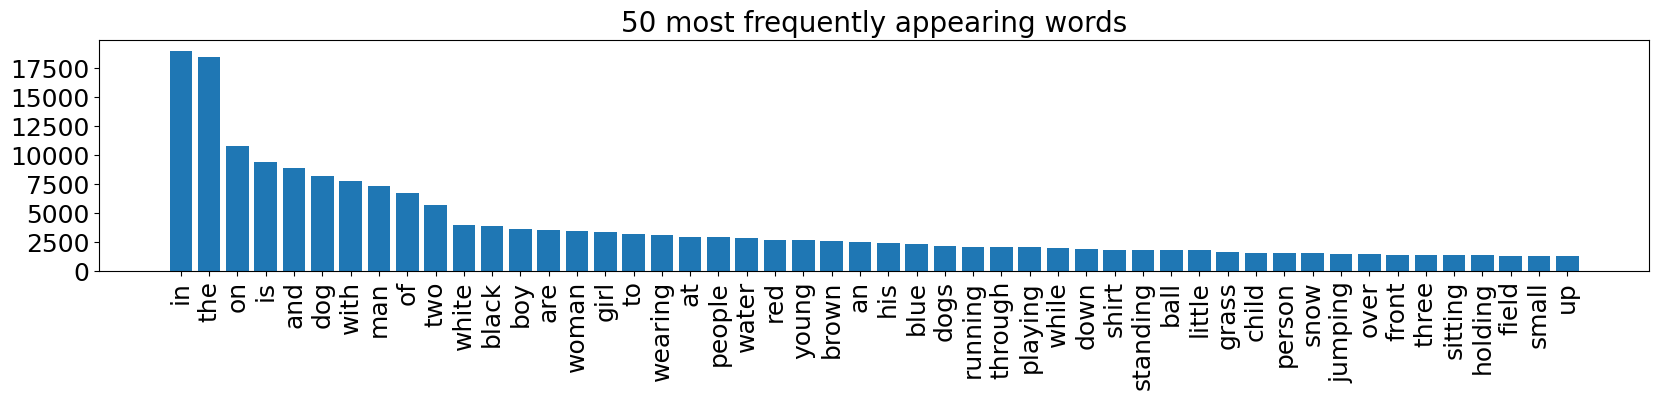

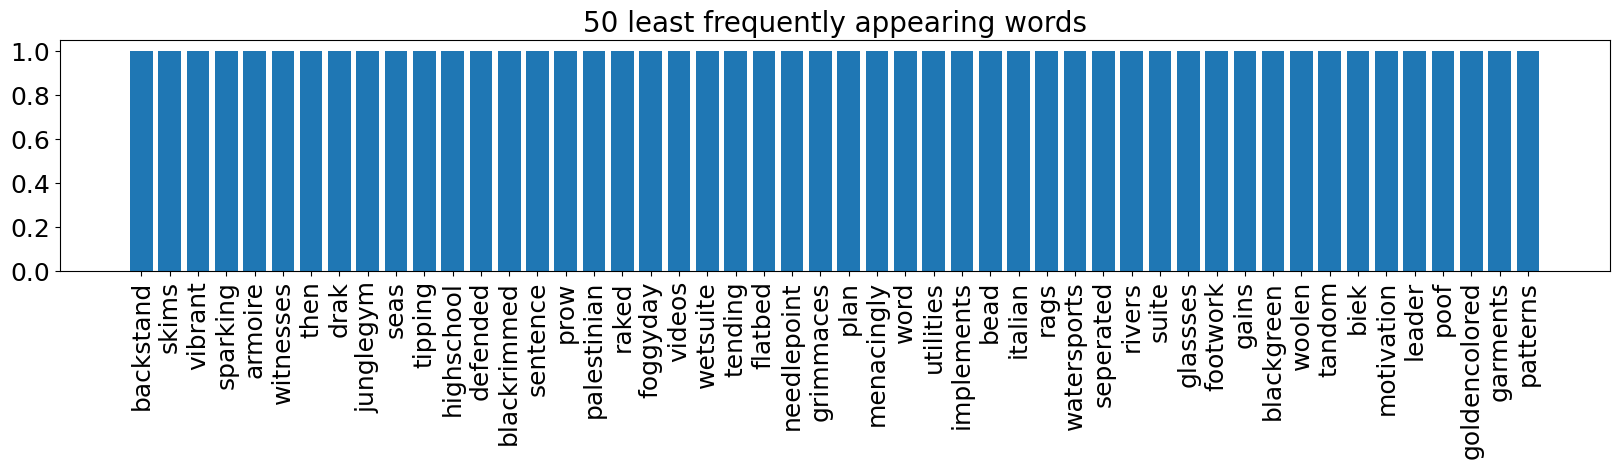

In [24]:
topn = 50

def plthist(dfsub, title="Plotting top 50 words that occur in the Cleaned Dataset"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=18)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=18)
    plt.title(title, fontsize=20)
    plt.show()
    
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:], title="50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:], title="50 least frequently appearing words")

In [25]:
from copy import copy
def add_tokens(captions):
    caps = []
    for txt in captions:
        txt = "startseq" + txt + " endseq"
        caps.append(txt)
    return caps
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_tokens(df_txt["caption"])
df_txt0.head(5)

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...

In [26]:
from keras.applications import VGG16

model_vgg = VGG16(include_top=True, weights='imagenet')
model_vgg.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [27]:
from keras import models
from keras.models import Sequential
model = Sequential()
for layer in model_vgg.layers[:-1]: # go through until last layer
    model.add(layer)
final_vgg_model = models.Model(inputs=model.inputs, outputs=model.layers[-1].output)

final_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224  #image size fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix, npix, 3)
data = np.zeros((len(jpgs), npix, npix, 3))
for i, name in enumerate(jpgs):
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = final_vgg_model.predict(nimage.reshape((1,)+ nimage.shape[:3]))
    images[name] = y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


In [29]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))

pca = PCA(n_components=2)

y_pca = pca.fit_transform(encoder)

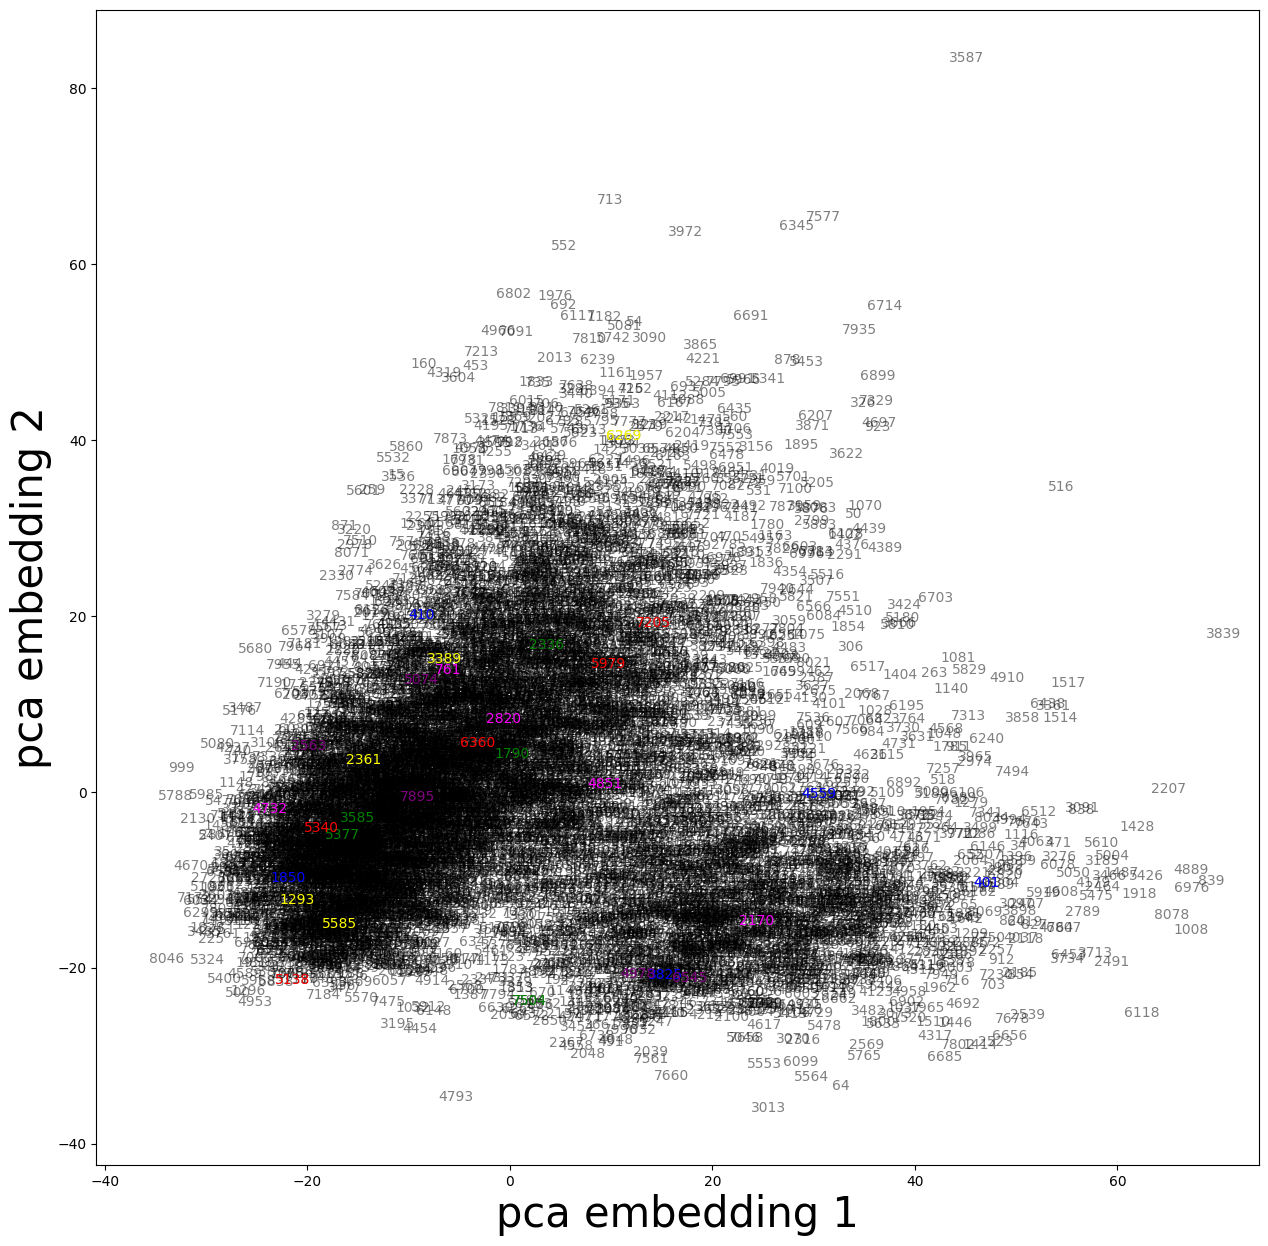

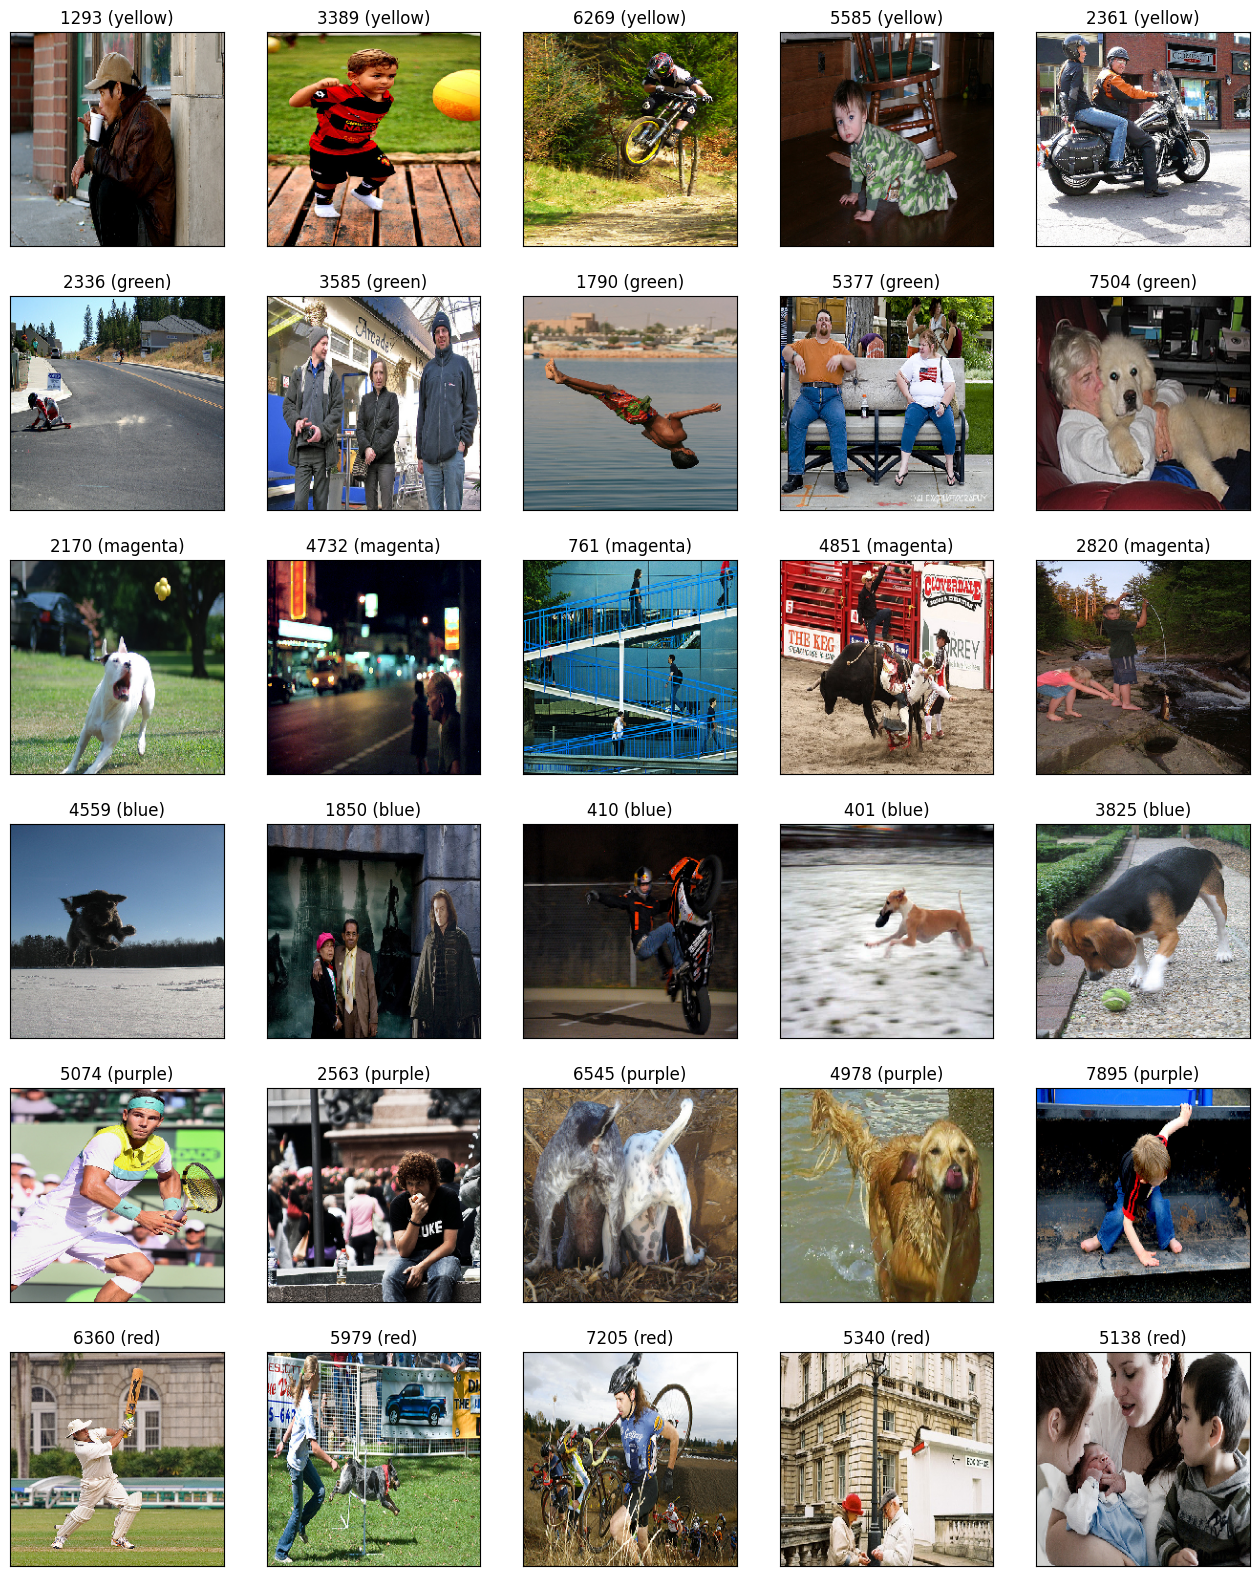

In [30]:

picked_picture = OrderedDict()
picked_picture["yellow"] = [1293, 3389, 6269, 5585, 2361]
picked_picture["green"] = [2336, 3585, 1790, 5377, 7504]
picked_picture["magenta"] = [2170, 4732, 761, 4851, 2820]
picked_picture["blue"] = [4559, 1850, 410, 401, 3825]
picked_picture["purple"] = [5074, 2563, 6545, 4978, 7895]
picked_picture["red"] = [6360, 5979, 7205, 5340, 5138]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0], y_pca[:,1], c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow, y_pca[irow,:], color="black", alpha=0.5)
for color, irows in picked_picture.items():
    for irow in irows:
        ax.annotate(irow, y_pca[irow, :], color=color)
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()

   
## plot the images
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_picture.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(len(picked_picture), 5, count, xticks=[], yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec, color))
plt.show()

In [ ]:
dimages, keepindex = [], []
# creating a dataframe where only first caption is taken for model training
df_txt0 = df_txt0.loc[df_txt0["index"].values == '0',:]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
# fname are the names of the image
fnames = df_txt0["filename"].iloc[keepindex].values
# dcaptions contains captions of the images
dcaptions = df_txt0["caption"] .iloc[keepindex].values
# dimages are the actual features of the images
dimages = np.array(dimages)

In [ ]:
df_txt0.head()

In [33]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocubulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:3])

Vocubulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2]]


In [34]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [35]:
maxlen = np.max([len(text) for text in dtexts])
minlen = np.min([len(text) for text in dtexts])
print("Min length of caption: {} and Max length of caption: {}".format(minlen, maxlen))

Min length of caption: 2 and Max length of caption: 30


In [36]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [37]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import ELU, PReLU, LeakyReLU
print(vocab_size)

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)

se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptionFeature2")(se2)
# combining model for decoder

decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation="relu")(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_4[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 30, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['CaptionFeature[0][0]']         
                                                                                       

In [38]:
# fit model
from time import time
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="log/{}".format(time()))

hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=6, verbose=2, batch_size=32, validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks=[tensorboard])

Epoch 1/6
1551/1551 - 269s - loss: 5.3189 - val_loss: 4.8128 - 269s/epoch - 174ms/step
Epoch 2/6
1551/1551 - 246s - loss: 4.4489 - val_loss: 4.5260 - 246s/epoch - 159ms/step
Epoch 3/6
1551/1551 - 247s - loss: 4.0556 - val_loss: 4.4731 - 247s/epoch - 159ms/step
Epoch 4/6
1551/1551 - 246s - loss: 3.7842 - val_loss: 4.4950 - 246s/epoch - 159ms/step
Epoch 5/6
1551/1551 - 244s - loss: 3.5694 - val_loss: 4.5763 - 244s/epoch - 158ms/step
Epoch 6/6
1551/1551 - 244s - loss: 3.3855 - val_loss: 4.6342 - 244s/epoch - 157ms/step


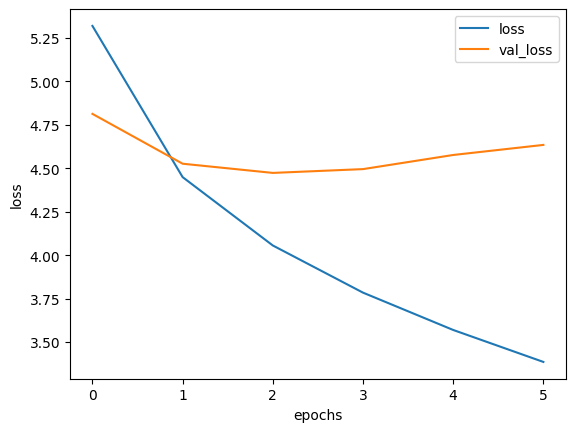

In [39]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

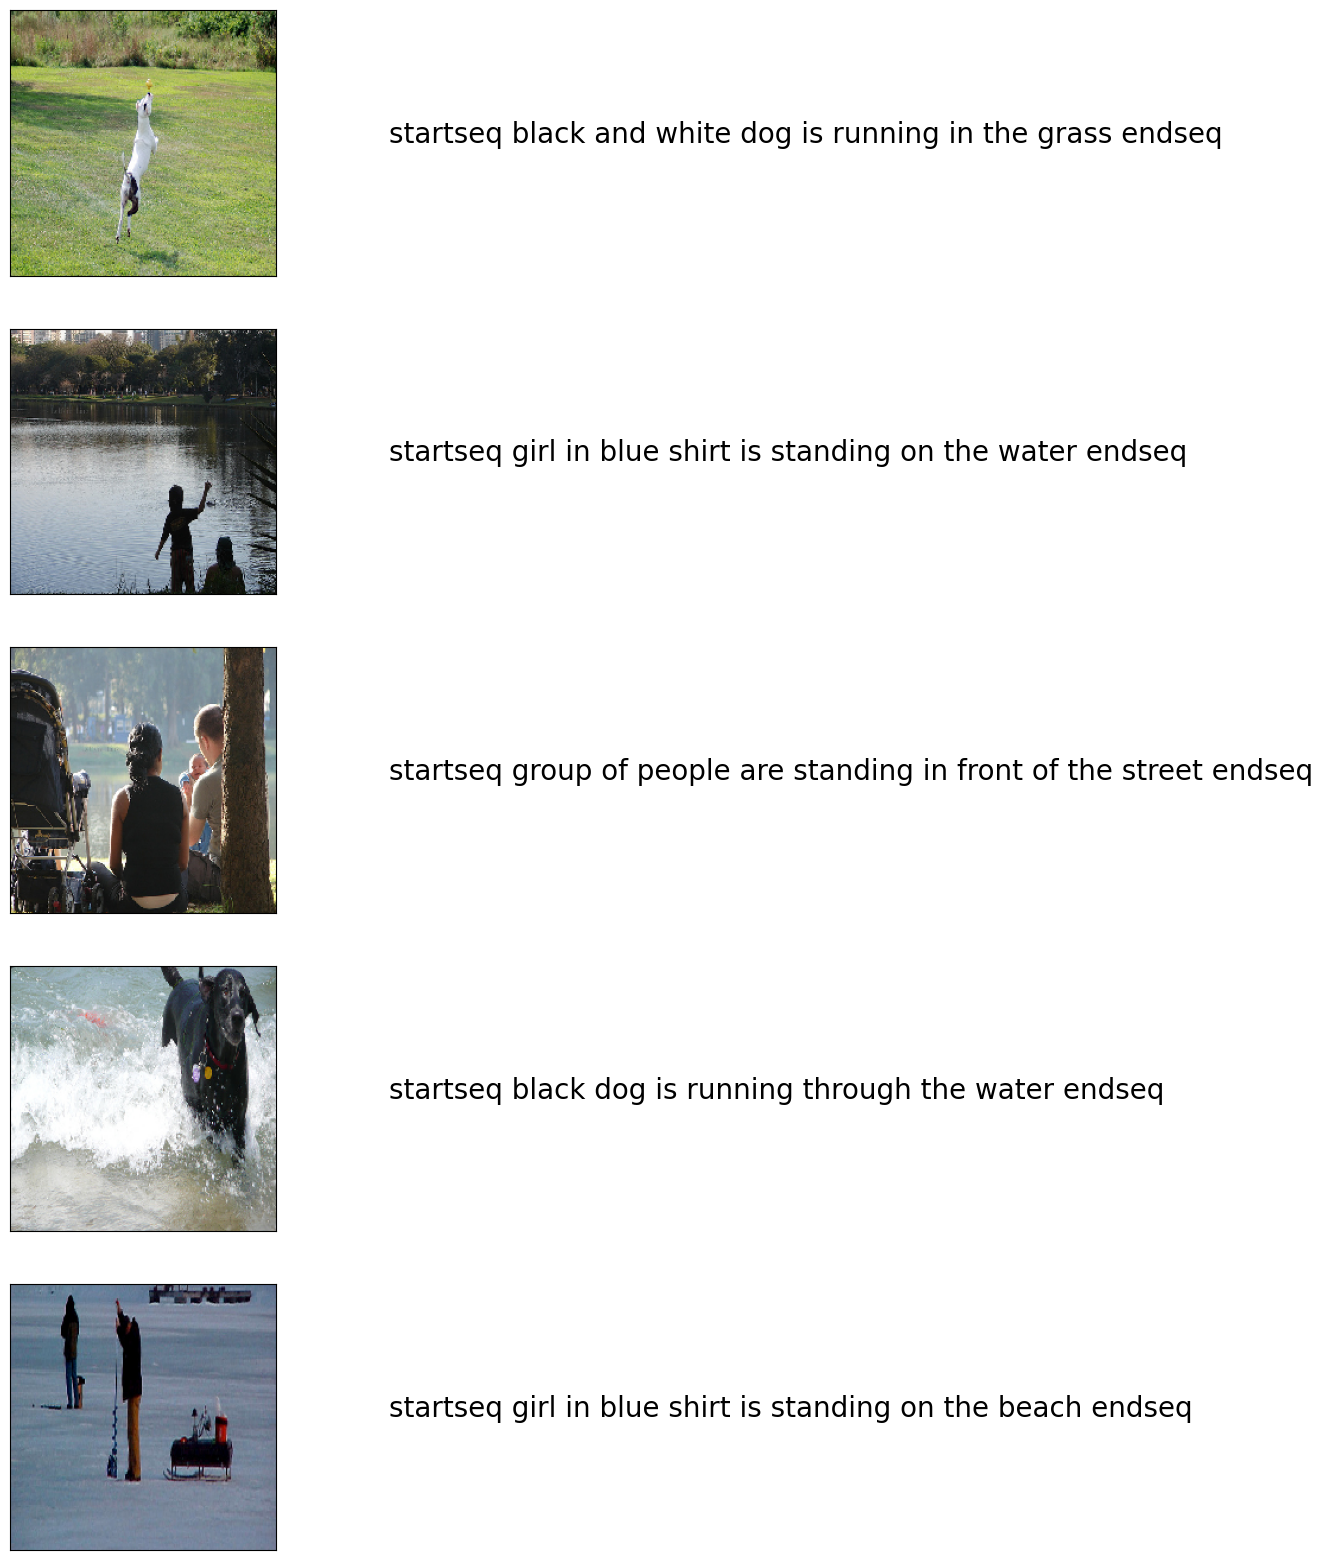

In [40]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    
    in_text = 'startseq'
    
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " "+ newword
        if newword == "endseq":
            break
    return in_text

npic = 5
npix = 224
target_size = (npix, npix, 3)
count = 1

fig = plt.figure(figsize=(10,20))


for jpgfnm, image_feature in zip(fnm_test[15:20], di_test[15:20]):
    ## images
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ## captions
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.5, caption, fontsize=20)
    count += 1
    
plt.show()
